In [162]:
import rasterio as rio
import matplotlib.pyplot as plt 
from matplotlib.colors import Normalize
import numpy as np
import numpy.matlib
from scipy import interpolate
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import scipy
import os, sys, pickle, gzip
import datetime
import geopy.distance
import xarray as xr
import pandas as pd
import geopandas as gpd
import shapely.geometry
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import cartopy.feature as cfeature
import itertools
import random
import metpy
from metpy.plots import USCOUNTIES

import warnings
warnings.filterwarnings('ignore')

dataDirDiscovery = '/dartfs-hpc/rc/lab/C/CMIG/ecoffel/data/projects/ag-land-climate'

In [163]:
run ../util/setupConsole

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [164]:
crop = 'Maize'
wxData = 'era5'

yieldDataOld = True

oldStr = 'new'
if yieldDataOld:
    oldStr = 'old'

selPointModel = 'kdd-gdd'

if wxData == '20cr':
    tempYearRange = [1970, 2015]
    if yieldDataOld:
        yieldYearRange = [1970, 2008]
    else:
        yieldYearRange = [1970, 2013]
else:
    tempYearRange = [1981, 2018]
    if yieldDataOld:
        yieldYearRange = [1981, 2008]
    else:
        yieldYearRange = [1981, 2013]

yearRange = np.intersect1d(np.arange(tempYearRange[0], tempYearRange[1]+1), np.arange(yieldYearRange[0], yieldYearRange[1]+1))

In [165]:
sacksLat = np.linspace(90, -90, 360)
sacksLon = np.linspace(0, 360, 720)

In [166]:
def findConsec(data):
    # find longest consequtative sequence of years with yield data
    ptMax = (-1, -1)
    ptCur = (-1, -1)
    for i, val in enumerate(data):
        # start sequence
        if ~np.isnan(val) and ptCur[0] == -1:
            ptCur = (i, -1)
        #end sequence
        elif (np.isnan(val) and ptCur[0] >= 0):
            ptCur = (ptCur[0], i)
            if ptCur[1]-ptCur[0] > ptMax[1]-ptMax[0] or ptMax == (-1, -1):
                ptMax = ptCur
            ptCur = (-1, -1)
        # reached end of sequence
        elif i >= len(data)-1 and ptCur[0] >= 0:
            ptCur = (ptCur[0], i)
            if ptCur[1]-ptCur[0] > ptMax[1]-ptMax[0] or ptMax == (-1, -1):
                ptMax = ptCur
    return ptMax

In [167]:
with gzip.open('%s/gdd-kdd-lat-%s.dat'%(dataDirDiscovery, wxData), 'rb') as f:
    tempLat = pickle.load(f)

with gzip.open('%s/gdd-kdd-lon-%s.dat'%(dataDirDiscovery, wxData), 'rb') as f:
    tempLon = pickle.load(f)


In [168]:
maizeYield = []
for year in range(yieldYearRange[0],yieldYearRange[1]+1):
    
    if yieldDataOld:
        curMaizeYield = xr.open_dataset('%s/deepak/Maize_yield/Maize_areaweightedyield_%d.nc'%(dataDirDiscovery, year), decode_cf=False)
    else:
        curMaizeYield = xr.open_dataset('%s/deepak/Maize_yield_1970_2013/Maize_areaweightedyield_%d_ver12b.nc'%(dataDirDiscovery, year), decode_cf=False)
    
    curMaizeYield['time'] = [year]
    if len(maizeYield) == 0:
        maizeYield = curMaizeYield
    else:
        maizeYield = xr.concat([maizeYield, curMaizeYield], dim='time')
    
maizeYield.load()

<xarray.Dataset>
Dimensions:    (latitude: 360, level: 1, longitude: 720, time: 28)
Coordinates:
  * latitude   (latitude) float64 89.75 89.25 88.75 ... -88.75 -89.25 -89.75
  * longitude  (longitude) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * level      (level) float64 1.0
  * time       (time) int64 1981 1982 1983 1984 1985 ... 2005 2006 2007 2008
Data variables:
    Data       (time, level, latitude, longitude) float64 nan nan ... nan nan

In [169]:
# flip latitude axis so top is +90
if not yieldDataOld:
    latDeepak = np.flipud(maizeYield.latitude.values)
else:
    latDeepak = maizeYield.latitude.values
lonDeepak = np.roll(maizeYield.longitude.values, int(len(maizeYield.longitude)/2), axis=0)
lonDeepak[lonDeepak<0] += 360
maizeYield['Data'] = maizeYield.Data.transpose('latitude', 'longitude', 'time', 'level')
if not yieldDataOld:
    data = np.roll(np.flip(maizeYield['Data'], axis=0), int(len(lonDeepak)/2), axis=1)
else:
    data = np.roll(maizeYield['Data'], int(len(lonDeepak)/2), axis=1)

In [170]:
maizeYield['latitude'] = latDeepak
maizeYield['longitude'] = lonDeepak
maizeYield['Data'] = (('latitude', 'longitude', 'time'), np.squeeze(data))

In [171]:
if wxData == 'cpc':
    with gzip.open('%s/seasonal-precip-maize-gpcp.dat'%dataDirDiscovery, 'rb') as f:
        seasonalPrecip = pickle.load(f)
elif wxData == 'era5':
    with gzip.open('%s/seasonal-precip-maize-era5.dat'%dataDirDiscovery, 'rb') as f:
        seasonalPrecip = pickle.load(f)

In [172]:
if os.path.isfile('%s/maize-trends-deepak-%s-%s.dat'%(dataDirDiscovery, crop, oldStr)):
    with open('%s/maize-trends-deepak-%s-%s.dat'%(dataDirDiscovery, crop, oldStr), 'rb') as f:
        maizeTrends = pickle.load(f)
        print('loaded %s'%('%s/maize-trends-deepak-%s-%s.dat'%(dataDirDiscovery, crop, oldStr)))
else:

    maizeTrends = np.full([len(latDeepak), len(lonDeepak)], np.nan)

    print('computing maize trends...')
    for xlat in range(len(latDeepak)):
        for ylon in range(len(lonDeepak)):
            y = np.squeeze(maizeYield.Data.values[xlat, ylon, :])

            nn = np.where(~np.isnan(y))[0]
            if len(nn) > 10:
                X = sm.add_constant(range(len(y[nn])))
                mdl = sm.OLS(y[nn], X).fit()
                maizeTrends[xlat, ylon] = mdl.params[1]
    
    with open('%s/maize-trends-deepak-%s-%s.dat'%(dataDirDiscovery, crop, oldStr), 'wb') as f:
        pickle.dump(maizeTrends, f)
        

loaded /dartfs-hpc/rc/lab/C/CMIG/ecoffel/data/projects/ag-land-climate/maize-trends-deepak-Maize-old.dat


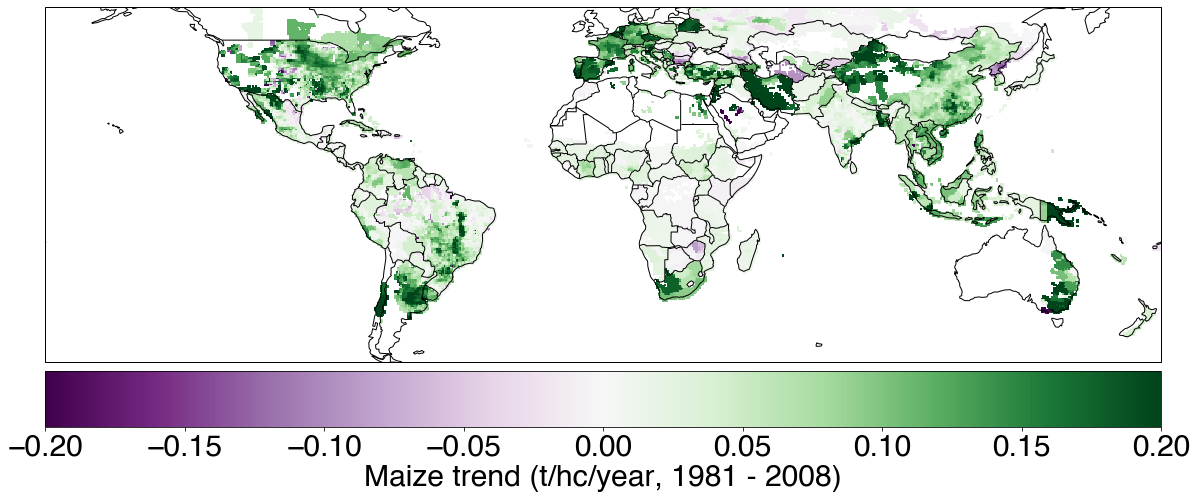

In [209]:
cRange=[-.2, .2]
f = plt.figure(figsize=(20,17))
ax = plt.axes(projection=ccrs.PlateCarree())
# c = plt.contourf(lonDeepak, latDeepak, np.clip(maizeTrends, cRange[0], cRange[1]), cmap='Greens', vmin=cRange[0], vmax=cRange[1], levels=np.linspace(cRange[0], cRange[1], 50))
c = plt.pcolormesh(lonDeepak, latDeepak[60:-70], np.clip(maizeTrends[60:-70, :], cRange[0], cRange[1]), cmap='PRGn', vmin=cRange[0], vmax=cRange[1])
ax.add_feature(cfeature.BORDERS)
cbar = plt.colorbar(c, orientation='horizontal', pad=0.01)
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, .05))
cbar.set_label('Maize trend (t/hc/year, 1981 - 2008)', fontsize=30)
cbar.ax.tick_params(labelsize=30)
ax.coastlines()
plt.savefig('global-deepak-old-yield-trends.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

In [174]:
with open('%s/global-point-model-data-%s-%s-%s.dat'%(dataDirDiscovery, wxData, crop, oldStr), 'rb') as f:
    print('loading saved data...')
    modelData = pickle.load(f)
    print('loaded %s'%('%s/global-point-model-data-%s-%s-%s.dat'%(dataDirDiscovery, wxData, crop, oldStr)))

loading saved data...
loaded /dartfs-hpc/rc/lab/C/CMIG/ecoffel/data/projects/ag-land-climate/global-point-model-data-era5-Maize-old.dat


In [175]:
if selPointModel == 'kdd-gdd-pr':
    pointModels = modelData['pointModels']
elif selPointModel == 'kdd-gdd':
    pointModels = modelData['pointModels_KDD_GDD']

pointModels_STD = modelData['pointModels_STD']

In [176]:
yieldKddCoef = np.full([len(latDeepak), len(lonDeepak)], np.nan)
yieldGddCoef = np.full([len(latDeepak), len(lonDeepak)], np.nan)
yieldPrCoef = np.full([len(latDeepak), len(lonDeepak)], np.nan)
yieldMdlKDDR2 = np.full([len(latDeepak), len(lonDeepak)], np.nan)
yieldMdlKDD_P = np.full([len(latDeepak), len(lonDeepak)], np.nan)
yieldMdlGDD_P = np.full([len(latDeepak), len(lonDeepak)], np.nan)
yieldMdlPr_P = np.full([len(latDeepak), len(lonDeepak)], np.nan)

for xlat in range(yieldKddCoef.shape[0]):
    
    if xlat % 25 == 0:
        print('%.0f %% done'%(xlat/yieldKddCoef.shape[0]*100))
    
    if xlat not in pointModels_STD.keys():
        if xlat not in pointModels.keys():
            continue
    
    for ylon in range(yieldKddCoef.shape[1]):
        
        if ylon not in pointModels_STD[xlat].keys():
            if ylon not in pointModels[xlat].keys():
                continue
        
        if xlat in pointModels.keys() and ylon in pointModels_STD[xlat].keys():
            yieldKddCoef[xlat, ylon] = pointModels_STD[xlat][ylon].params['KDD']
            yieldGddCoef[xlat, ylon] = pointModels_STD[xlat][ylon].params['GDD']
        
            if 'pr' in selPointModel:
                yieldPrCoef[xlat, ylon] = pointModels_STD[xlat][ylon].params['Pr']
        
        if xlat in pointModels.keys() and ylon in pointModels[xlat].keys():
            yieldMdlKDDR2[xlat, ylon] = pointModels[xlat][ylon].rsquared
            yieldMdlKDD_P[xlat, ylon] = pointModels[xlat][ylon].pvalues['KDD']
            yieldMdlGDD_P[xlat, ylon] = pointModels[xlat][ylon].pvalues['GDD']
            if 'pr' in selPointModel:
                yieldMdlPr_P[xlat, ylon] = pointModels[xlat][ylon].pvalues['Pr']
        

0 % done
7 % done
14 % done
21 % done
28 % done
35 % done
42 % done
49 % done
56 % done
62 % done
69 % done
76 % done
83 % done
90 % done
97 % done


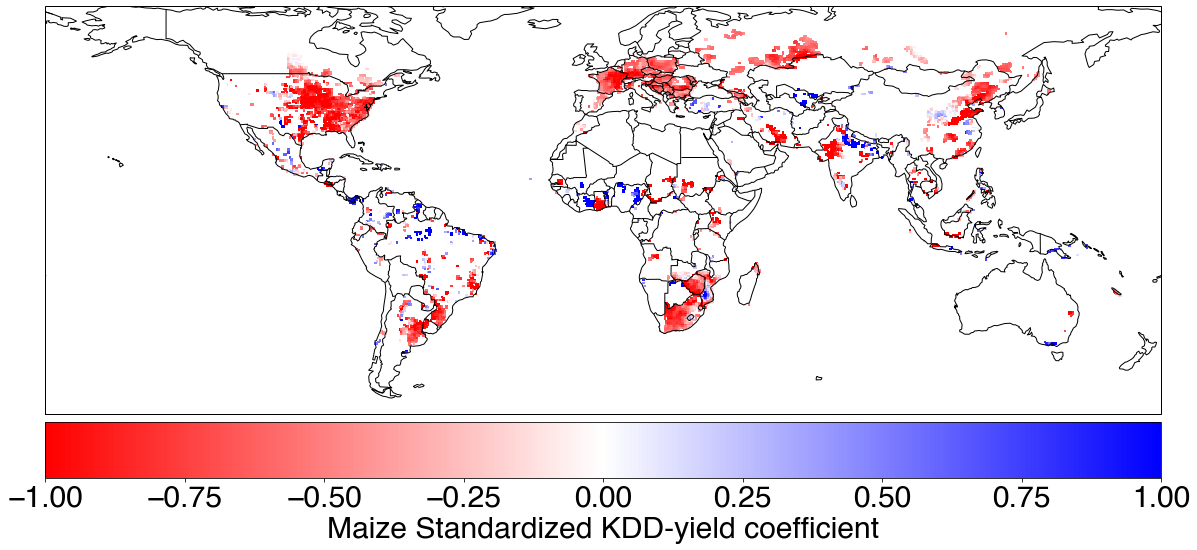

In [177]:
yieldKddCoef_filtered = yieldKddCoef.copy()#/np.nanmean(maizeYield.Data.values, axis=2)*100

cRange=[-1, 1]
f = plt.figure(figsize=(20,15))
ax = plt.axes(projection=ccrs.PlateCarree())
c = plt.pcolormesh(lonDeepak, latDeepak[50:-70], np.clip(yieldKddCoef_filtered[50:-70, :], cRange[0], cRange[1]), cmap='bwr_r', vmin=cRange[0], vmax=cRange[1])
ax.add_feature(cfeature.BORDERS)
cbar = plt.colorbar(c, orientation='horizontal', pad=0.01)
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, .25))
cbar.set_label('%s Standardized KDD-yield coefficient'%crop, fontsize=30)
cbar.ax.tick_params(labelsize=30)
ax.coastlines()
plt.savefig('global-deepak-kdd-coef-%s.png'%wxData, format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

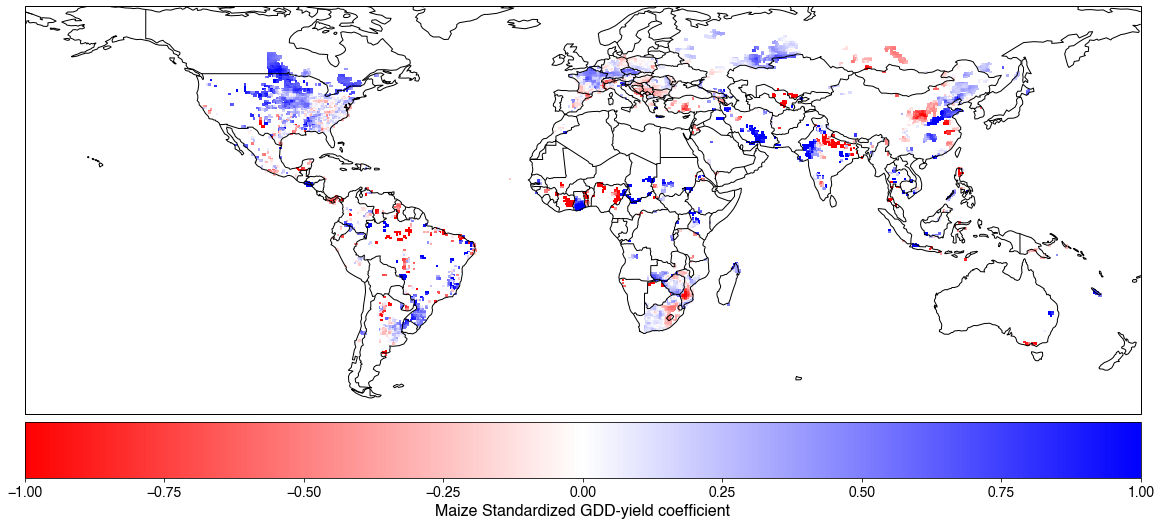

In [178]:
yieldGddCoef_filtered = yieldGddCoef.copy()#/np.nanmean(maizeYield.Data.values, axis=2)*100

cRange=[-1, 1]
f = plt.figure(figsize=(20,15))
ax = plt.axes(projection=ccrs.PlateCarree())
# c = plt.contourf(lonDeepak, latDeepak, np.clip(yieldKddCoef, cRange[0], cRange[1]), cmap='bwr', vmin=cRange[0], vmax=cRange[1])
c = plt.pcolormesh(lonDeepak, latDeepak[50:-70], np.clip(yieldGddCoef_filtered[50:-70, :], cRange[0], cRange[1]), cmap='bwr_r', vmin=cRange[0], vmax=cRange[1])
ax.add_feature(cfeature.BORDERS)
cbar = plt.colorbar(c, orientation='horizontal', pad=0.01)
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, .25))
cbar.set_label('%s Standardized GDD-yield coefficient'%crop)
ax.coastlines()

In [179]:
if 'pr' in selPointModel:
    yieldPrCoef_filtered = yieldPrCoef.copy()#/np.nanmean(maizeYield.Data.values, axis=2)
    # yieldPrCoef_filtered[yieldMdlKDDR2<=0.2] = np.nan

    cRange=[-1, 1]
    f = plt.figure(figsize=(20,15))
    ax = plt.axes(projection=ccrs.PlateCarree())
    # c = plt.contourf(lonDeepak, latDeepak, np.clip(yieldKddCoef, cRange[0], cRange[1]), cmap='bwr', vmin=cRange[0], vmax=cRange[1])
    c = plt.pcolormesh(lonDeepak, latDeepak[50:-70], np.clip(yieldPrCoef_filtered[50:-70, :], cRange[0], cRange[1]), cmap='BrBG', vmin=cRange[0], vmax=cRange[1])
    ax.add_feature(cfeature.BORDERS)
    cbar = plt.colorbar(c, orientation='horizontal', pad=0.01)
    cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, 1))
    cbar.set_label('%s Pr-yield coefficient (%% mean yield per additional mm/day)'%crop)
    ax.coastlines()

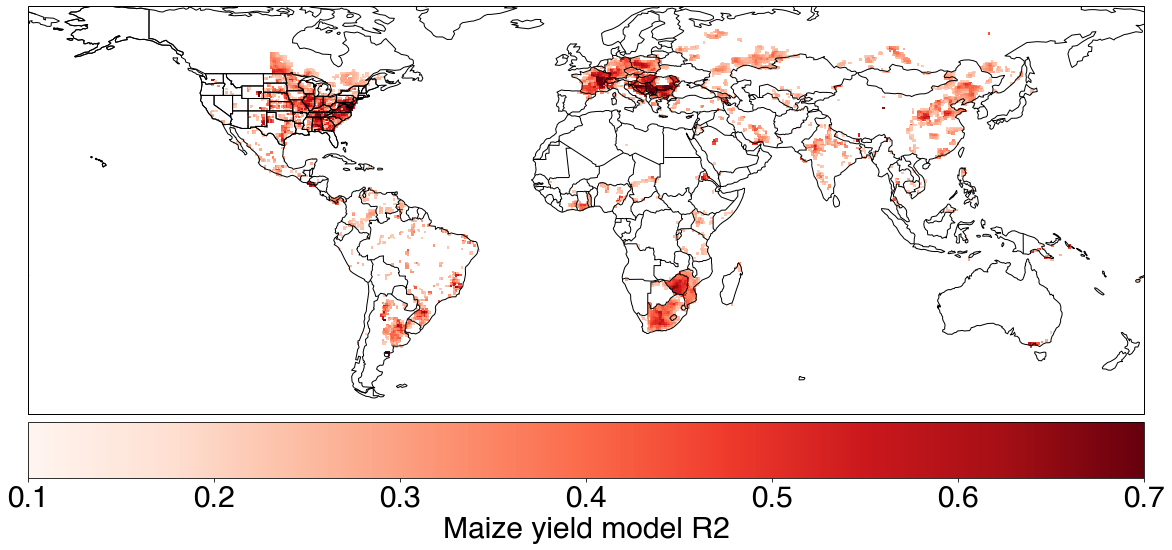

In [180]:
cRange=[.1, .7]
f = plt.figure(figsize=(20,15))
ax = plt.axes(projection=ccrs.PlateCarree())
# c = plt.contourf(lonDeepak, latDeepak, np.clip(yieldMdlR2, cRange[0], cRange[1]), cmap='Reds', vmin=cRange[0], vmax=cRange[1], levels=np.linspace(cRange[0], cRange[1], 50))
c = plt.pcolormesh(lonDeepak, latDeepak[50:-70], np.clip(yieldMdlKDDR2[50:-70,:], cRange[0], cRange[1]), cmap='Reds', vmin=cRange[0], vmax=cRange[1])
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
cbar = plt.colorbar(c, orientation='horizontal', pad=0.01)
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, .1))
cbar.set_label('%s yield model R2'%crop, fontsize=30)
cbar.ax.tick_params(labelsize=30)
ax.coastlines()

plt.savefig('deepak-old-model-r2-%s.png'%wxData, format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0)

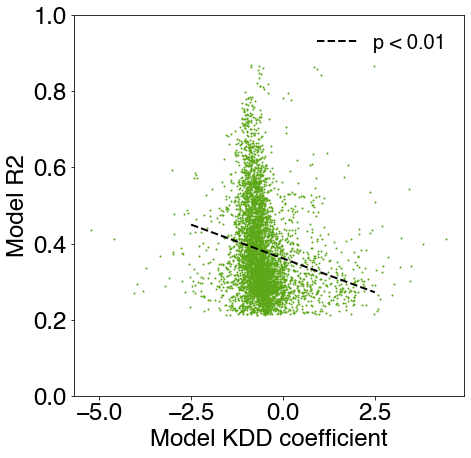

In [181]:
ykdd = np.reshape(yieldKddCoef_filtered, [yieldKddCoef_filtered.shape[0]*yieldKddCoef_filtered.shape[1]])
yr2 = np.reshape(yieldMdlKDDR2, [yieldMdlKDDR2.shape[0]*yieldMdlKDDR2.shape[1]])

nn = np.where((~np.isnan(ykdd)) & (~np.isnan(yr2)) & (ykdd != 0) & (yr2 != 0))[0]

X = sm.add_constant(ykdd[nn])
mdl = sm.OLS(yr2[nn], X).fit()
mdl.summary()

mdlInt = mdl.params[0]
mdlSlp = mdl.params[1]

x1 = -2.5
x2 = 2.5

plt.figure(figsize=(7,7))
plt.ylim([0,1])
plt.scatter(ykdd[nn],yr2[nn], c='#5ba718', s=1)
plt.plot([x1, x2], [mdlInt+x1*mdlSlp, mdlInt+x2*mdlSlp], '--k', lw=2, label='p < 0.01')
plt.xlabel('Model KDD coefficient', fontsize=24)
plt.ylabel('Model R2', fontsize=24)
plt.gca().tick_params(axis='x', labelsize=24)
plt.gca().tick_params(axis='y', labelsize=24)
l1 = plt.legend(prop = {'size':20, 'family':'Helvetica'})
l1.get_frame().set_linewidth(0)
# plt.savefig('global-model-kdd-coef-vs-r2.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

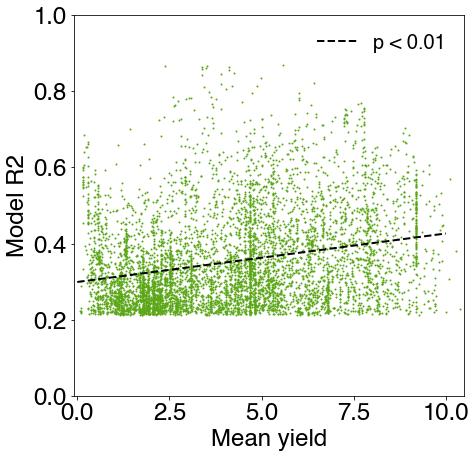

In [182]:
yyield = np.reshape(np.nanmean(maizeYield.Data.values, axis=2), [maizeYield.Data.values.shape[0]*maizeYield.Data.values.shape[1],1])
yr2 = np.reshape(yieldMdlKDDR2, [yieldMdlKDDR2.shape[0]*yieldMdlKDDR2.shape[1],1])

nn = np.where(((~np.isnan(yyield)) & (~np.isnan(yr2)) & (yyield != 0) & (yr2 != 0)))[0]


X = sm.add_constant(yyield[nn])
mdl = sm.OLS(yr2[nn], X).fit()
mdl.summary()

mdlInt = mdl.params[0]
mdlSlp = mdl.params[1]

plt.figure(figsize=(7,7))
plt.xlim([-0.1, 10.5])
plt.ylim([0,1])
plt.scatter(yyield[nn],yr2[nn], c='#5ba718', s=1)
plt.plot([0, 10], [mdlInt+0*mdlSlp, mdlInt+10*mdlSlp], '--k', lw=2, label='p < 0.01')
plt.xlabel('Mean yield', fontsize=24)
plt.ylabel('Model R2', fontsize=24)
plt.gca().tick_params(axis='x', labelsize=24)
plt.gca().tick_params(axis='y', labelsize=24)
l1 = plt.legend(prop = {'size':20, 'family':'Helvetica'})
l1.get_frame().set_linewidth(0)
# plt.savefig('global-model-yield-vs-r2.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

In [183]:
with open('%s/global-yield-projections-trendMethod-%s-%s-%s'%(dataDirDiscovery, crop, wxData, oldStr), 'rb') as f:
    globalYieldProj = pickle.load(f)
    if selPointModel == 'kdd-gdd-pr':
        yieldProj = globalYieldProj['yieldProj']
    elif selPointModel == 'kdd-gdd':
        yieldProj = globalYieldProj['yieldProj_KDD_GDD']
    globalKddChg = globalYieldProj['globalKddChg']
    globalGddChg = globalYieldProj['globalGddChg']
    globalPrChg = globalYieldProj['globalPrChg']
    
    print('loaded %s'%('%s/global-yield-projections-trendMethod-%s-%s-%s'%(dataDirDiscovery, crop, wxData, oldStr)))

loaded /dartfs-hpc/rc/lab/C/CMIG/ecoffel/data/projects/ag-land-climate/global-yield-projections-trendMethod-Maize-era5-old


In [194]:
pp=np.nanmean(globalPrChg,axis=2)
kk=np.nanmean(globalKddChg,axis=2)


(360, 720, 100)

In [205]:
yieldProjR2Filter = yieldProj.copy()
# yieldProjR2Filter[yieldProjR2Filter>25]=np.nan
yieldProjR2Filter = np.nanmean(yieldProjR2Filter, axis=2)
# yieldProjR2Filter[yieldMdlKDDR2<0.1]=np.nan

meanYield = np.nanmean(maizeYield.Data.values, axis=2)

In [206]:
# latBound = np.where(sacksLat < 20)[0]
# lonBound = np.where((sacksLon < 50) | (sacksLon > 330))[0]

latBoundEU = np.where((latDeepak < 60) & (latDeepak > 20))[0]
lonBoundEU = np.where((lonDeepak < 40) | (lonDeepak > 330))[0]

latBoundNA = np.where((latDeepak < 60) & (latDeepak > 20))[0]
lonBoundNA = np.where((lonDeepak < 280) & (lonDeepak > 200))[0]

latBoundSA = np.where((latDeepak < 20))[0]
lonBoundSA = np.where((lonDeepak < 330) & (lonDeepak > 200))[0]

latBoundAfrica = np.where((latDeepak < 20))[0]
lonBoundAfrica = np.where((lonDeepak > 330) | (lonDeepak < 40))[0]

latBoundChina = np.where((latDeepak < 50) & (latDeepak > 15))[0]
lonBoundChina = np.where((lonDeepak > 50) & (lonDeepak < 200))[0]

latBound = latBoundSA
lonBound = lonBoundSA
for xlat in range(len(latDeepak)):
    for ylon in range(len(lonDeepak)):
        if xlat not in latBound or ylon not in lonBound:
            yieldProjR2Filter[xlat, ylon] = np.nan
            meanYield[xlat, ylon] = np.nan


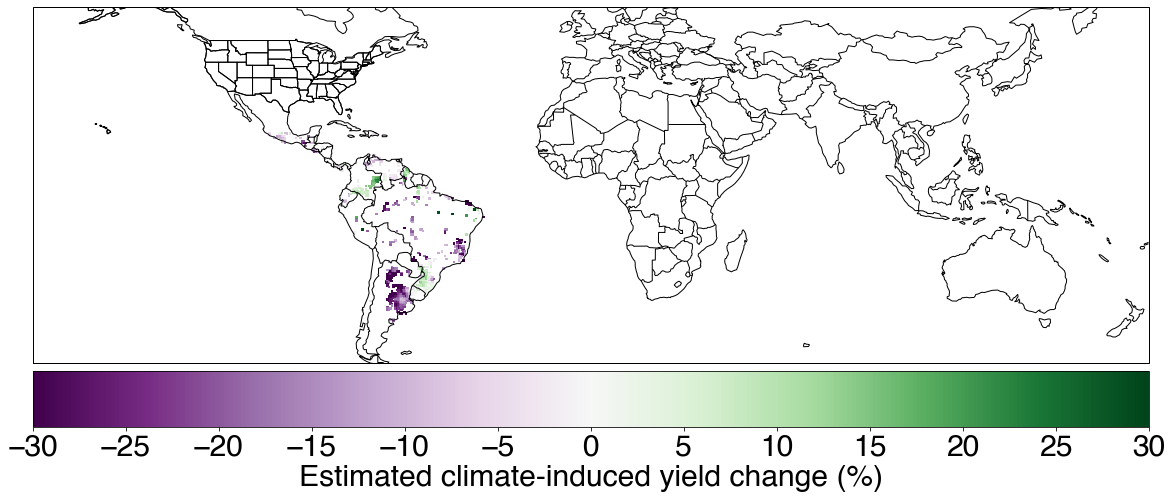

In [207]:
cRange=[-30, 30]
f = plt.figure(figsize=(20,15))
ax = plt.axes(projection=ccrs.PlateCarree())
c = plt.pcolormesh(lonDeepak, latDeepak[70:-80], np.clip(yieldProjR2Filter[70:-80,:], cRange[0], cRange[1]), cmap='PRGn', vmin=cRange[0], vmax=cRange[1])
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
cbar = plt.colorbar(c, orientation='horizontal', pad=0.01)
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, 5))
cbar.ax.tick_params(labelsize=30)
cbar.set_label('Estimated climate-induced yield change (%)', fontsize=30)
ax.coastlines()
plt.savefig('global-model-yield-chg-%s-%s.png'%(wxData, selPointModel), format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

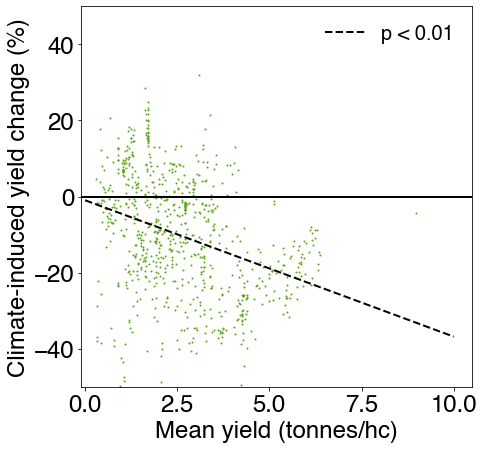

In [208]:
yyield = np.reshape(meanYield, [meanYield.shape[0]*meanYield.shape[1],1])
yProjChg = np.reshape(yieldProjR2Filter, [yieldProjR2Filter.shape[0]*yieldProjR2Filter.shape[1],1])

nn = np.where((~np.isnan(yyield)) & (~np.isnan(yProjChg)) & (yProjChg != 0))[0]


X = sm.add_constant(yyield[nn])
mdl = sm.OLS(yProjChg[nn], X).fit()
mdl.summary()

mdlInt = mdl.params[0]
mdlSlp = mdl.params[1]

plt.figure(figsize=(7,7))
plt.xlim([-0.1, 10.5])
plt.ylim([-50,50])
plt.scatter(yyield[nn],yProjChg[nn], c='#5ba718', s=1)
plt.plot([0, 10], [mdlInt+0*mdlSlp, mdlInt+10*mdlSlp], '--k', lw=2, label='p < 0.01')
plt.plot([-.1,10.5], [0,0], '-k', lw=2)
plt.xlabel('Mean yield (tonnes/hc)', fontsize=24)
plt.ylabel('Climate-induced yield change (%)', fontsize=24)
plt.gca().tick_params(axis='x', labelsize=24)
plt.gca().tick_params(axis='y', labelsize=24)
l1 = plt.legend(prop = {'size':20, 'family':'Helvetica'})
l1.get_frame().set_linewidth(0)
# plt.savefig('global-model-yield-vs-r2.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

In [188]:
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     24.95
Date:                Thu, 30 Apr 2020   Prob (F-statistic):           6.05e-07
Time:                        16:02:51   Log-Likelihood:                -28018.
No. Observations:                6339   AIC:                         5.604e+04
Df Residuals:                    6337   BIC:                         5.605e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.7687      0.502    -21.445      0.000     -11.753      -9.784
x1             0.5148      0.103      4.995      0.000       0.313       0.717
==============================================================================
Omnibus:                      541.533   Durbin-Watson:                   0.481
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1304.525
Skew:                          -0.515   Prob(JB):                    5.32e-284
Kurtosis:                       4.969   Cond. No.                         10.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

(array([ 1.,  1.,  1.,  7., 15., 24., 25., 15.,  8.,  3.]),
 array([-8.29400767, -8.25174671, -8.20948575, -8.16722478, -8.12496382,
        -8.08270286, -8.04044189, -7.99818093, -7.95591997, -7.913659  ,
        -7.87139804]),
 <a list of 10 Patch objects>)

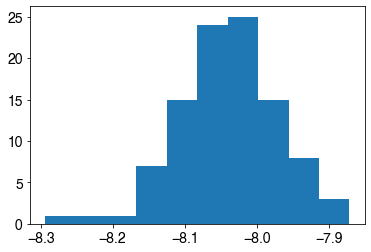

In [189]:
plt.hist(np.nanmean(np.nanmean(yieldProj,axis=0),axis=0))

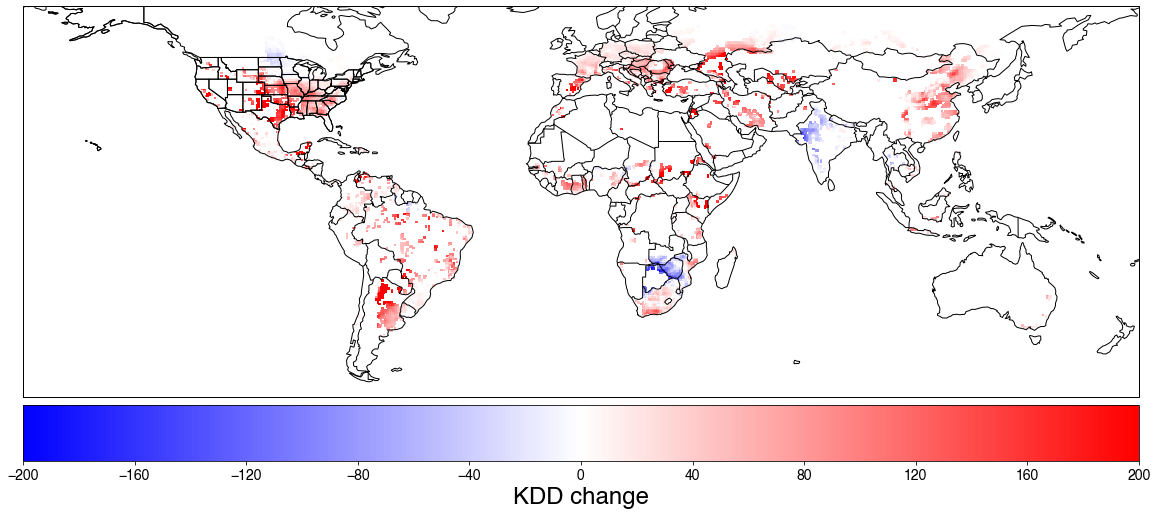

In [190]:
cRange=[-200, 200]
f = plt.figure(figsize=(20,15))
ax = plt.axes(projection=ccrs.PlateCarree())
# c = plt.contourf(lonDeepak, latDeepak, np.clip(globalKddChg, cRange[0], cRange[1]), cmap='bwr', vmin=cRange[0], vmax=cRange[1], levels=np.linspace(cRange[0], cRange[1], 50))
c = plt.pcolormesh(lonDeepak, latDeepak[60:-70], np.clip(np.nanmean(globalKddChg[60:-70,:,:], axis=2), cRange[0], cRange[1]), cmap='bwr', vmin=cRange[0], vmax=cRange[1])
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
cbar = plt.colorbar(c, orientation='horizontal', pad=0.01)
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, 40))
cbar.set_label('KDD change', fontsize=24)
ax.coastlines()

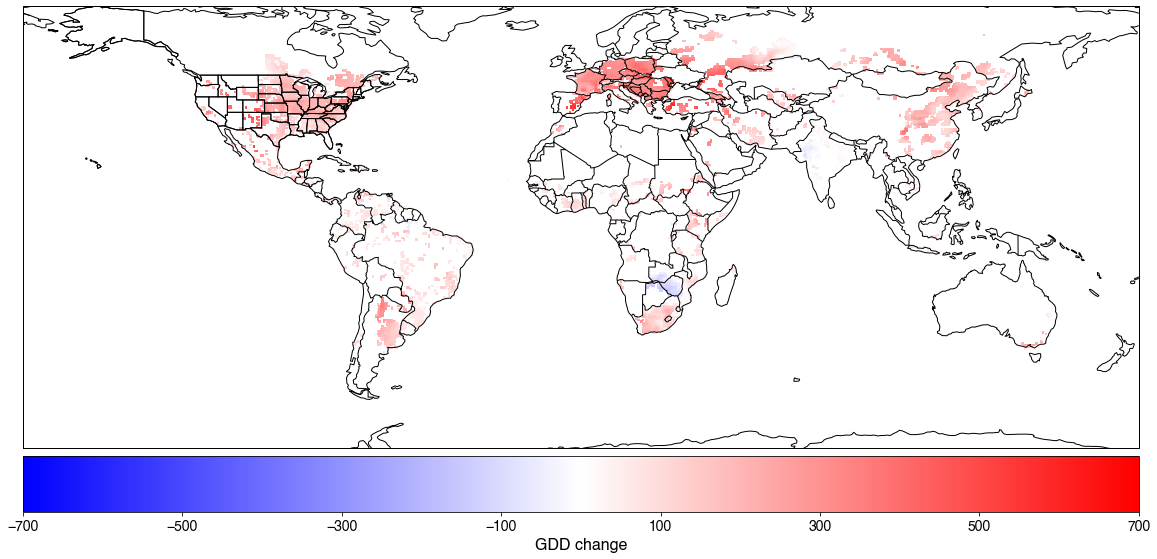

In [191]:
cRange=[-700, 700]
f = plt.figure(figsize=(20,15))
ax = plt.axes(projection=ccrs.PlateCarree())
# c = plt.contourf(lonDeepak, latDeepak, np.clip(globalKddChg, cRange[0], cRange[1]), cmap='bwr', vmin=cRange[0], vmax=cRange[1], levels=np.linspace(cRange[0], cRange[1], 50))
c = plt.pcolormesh(lonDeepak, latDeepak[50:-50], np.clip(np.nanmean(globalGddChg[50:-50,:,:], axis=2), cRange[0], cRange[1]), cmap='bwr', vmin=cRange[0], vmax=cRange[1])
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
cbar = plt.colorbar(c, orientation='horizontal', pad=0.01)
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, 200))
cbar.set_label('GDD change')
ax.coastlines()

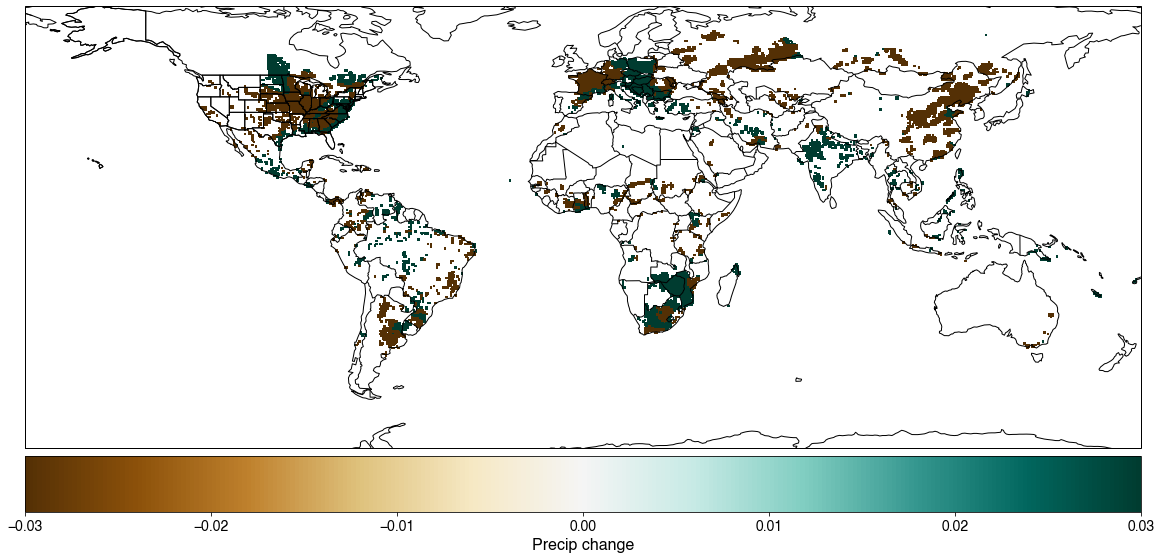

In [192]:
cRange=[-.03, .03]
f = plt.figure(figsize=(20,15))
ax = plt.axes(projection=ccrs.PlateCarree())
# c = plt.contourf(lonDeepak, latDeepak, np.clip(globalKddChg, cRange[0], cRange[1]), cmap='bwr', vmin=cRange[0], vmax=cRange[1], levels=np.linspace(cRange[0], cRange[1], 50))
c = plt.pcolormesh(lonDeepak, latDeepak[50:-50], np.clip(np.nanmean(globalPrChg[50:-50,:,:], axis=2), cRange[0], cRange[1]), cmap='BrBG', vmin=cRange[0], vmax=cRange[1])
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
cbar = plt.colorbar(c, orientation='horizontal', pad=0.01)
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, .01))
cbar.set_label('Precip change')
ax.coastlines()

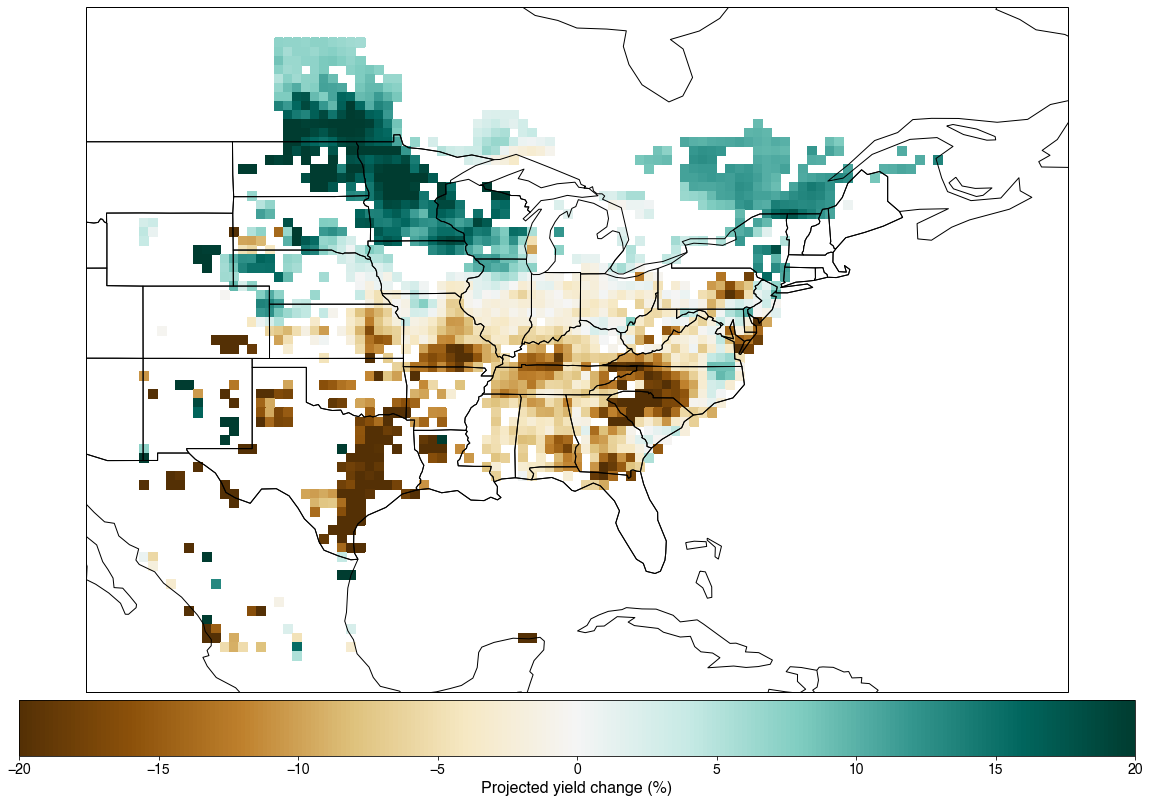

In [193]:
cRange=[-20, 20]
f = plt.figure(figsize=(20,15))
ax = plt.axes(projection=ccrs.PlateCarree())
# c = plt.contourf(lonDeepak, latDeepak, np.clip(yieldProj, cRange[0], cRange[1]), cmap='BrBG', vmin=cRange[0], vmax=cRange[1], levels=np.linspace(cRange[0], cRange[1], 50))
c = plt.pcolormesh(lonDeepak[500:600], latDeepak[70:140], np.clip(yieldProjR2Filter[70:140,500:600], cRange[0], cRange[1]), cmap='BrBG', vmin=cRange[0], vmax=cRange[1])
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
cbar = plt.colorbar(c, orientation='horizontal', pad=0.01)
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, 5))
cbar.set_label('Projected yield change (%)')
ax.coastlines()